In [2]:
import numpy as np
import pandas as pd
from scanpy import read_h5ad
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
%pylab inline
import seaborn as sns
from scipy.cluster.hierarchy import fcluster



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# load mosta data
x = read_h5ad('Mouse_embryo_all_stage.h5ad')
gene_info = pd.read_table('mm10.ncbiRefSeq.gtf',comment='#',header = None)
gene_info = gene_info[gene_info[2]=='transcript']

# load gene features and subset to detected genes
feats = pd.read_pickle('hg38_mm10_1k_features.pkl')
gene_info['symbol'] = [a.split(';')[0].split('"')[-2] for a in gene_info[8]]
gene_info['id'] = [a.split(';')[1].split('"')[-2].split('.')[0] for a in gene_info[8]]
feat_ids = pd.Series(['_'.join(a[:2]) for a in feats.index.str.split('_')],index = feats.index)
common = set(feat_ids.values).intersection(gene_info['id'])
mm10_feats = feats.loc[feat_ids[feat_ids.isin(common)].index.values]
gene_dict = gene_info[gene_info['id'].isin(common)][['id','symbol']].drop_duplicates().set_index('id')['symbol'].to_dict()
mm10_feats['gene_symbol'] = feat_ids.loc[mm10_feats.index].map(gene_dict)
mm10_avs = mm10_feats.groupby('gene_symbol').mean()
sel_feat = sorted(set(mm10_avs.index).intersection(x.var.index))


# extract gene expression and coordinates from mosta data
gex = x[:,sel_feat].to_df()
coords = pd.DataFrame(np.array([[int(i) for i in a.split('-')[0].split('_')] for a in x.obs.index]),index = x.obs.index)
gene_features = mm10_avs.loc[sel_feat].values


# transfer to gpu
torch.cuda.set_device(3)
tp = {}
for k,v in x.obs.groupby(x.obs['timepoint'].cat.codes).groups.items():
    if k>=4:
        continue
    tp[k] = (coords.loc[v], torch.from_numpy(gex.loc[v].values).float())
    print(k)

for k,v in tp.items():
    tp[k] = (v[0],v[1].cuda())

0
1
2
3


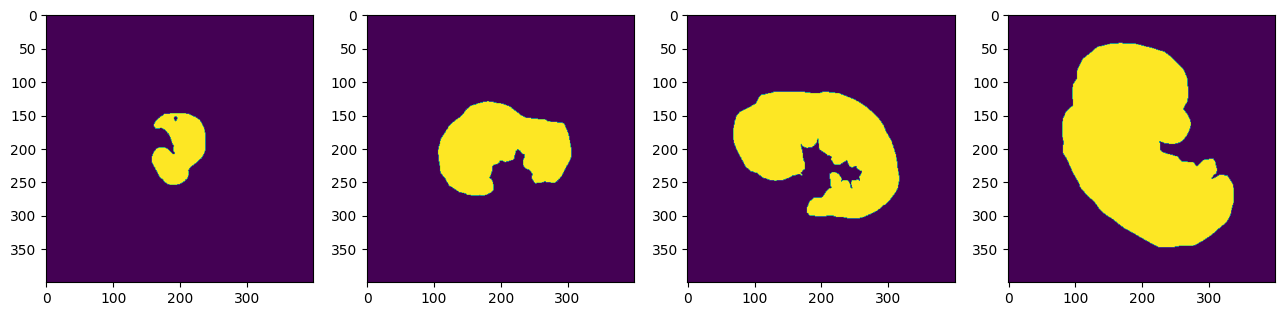

In [4]:
# center and scale
zero_pos = {}
pos = {}
nonzero_ims = {}

yshifts = [0,0,0,0,1]
xshifts = [0,0,0,0,1]

size = 400    
sf = 1 #sf = 1 so no downsampling
plt.figure(figsize = (20,5))
# define gex positions and zero positions and visualize these
for k in range(4):
    coo, _ = tp[k]
    img = np.zeros((size,size))
    pos[k] = ((size-1)//2 + coo.values//sf - coo.values.mean(axis = 0,keepdims = True)/sf).astype(int)
    pos[k][:,0]+= yshifts[k]
    pos[k][:,1]+=xshifts[k]
    img[(pos[k][:,0], pos[k][:,1])] += 1
    zer = np.array(np.where(img==0)).T
    m = np.mean(img)
    nonzero_ims[k] = img.copy()
    
    ratio = (1-m)/m
    zero_pos[k] = (zer, np.arange(len(zer)),(1-m)/m)


    
    plt.subplot(1,5,k+1)
    plt.imshow(img)


plt.show()


idxs = {i : np.arange(len(tp[i][0])) for i in tp}

In [5]:
from scipy.spatial.distance import cdist

/tmp/ipykernel_4026262/3571767470.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(val_pos[i][:,0],val_pos[i][:,1],c=sns.color_palette('tab10',12)[i],s=0.1)


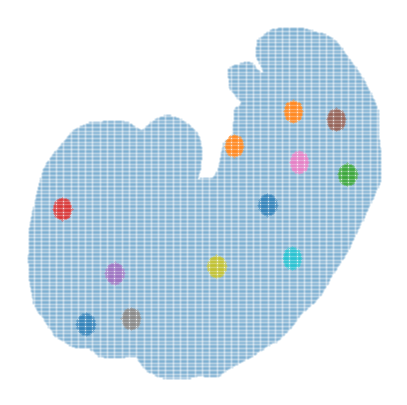

In [6]:
#create the validation dataset

#timepoint 3 = E12.5
np.random.seed(60)

#random sample centers
val = pos[3][np.random.choice(np.arange(pos[3].shape[0]), 12)]

#compute distances to centers
dist_to_val = cdist(pos[3],val)

# define train/val positions by distance
train_pos = pos[3][np.where(dist_to_val.min(axis=1)>8)]
train_ind = np.where(dist_to_val.min(axis=1)>8)[0]
val_ind = {i:np.where(dist_to_val[:,i]<=8)[0] for i in range(12)}
val_border = {i:np.where((dist_to_val[:,i]>8) & (dist_to_val[:,i]<=9))[0] for i in range(12)}
val_pos = {i:pos[3][np.where(dist_to_val[:,i]<=8)] for i in range(12)}
figsize(5,5)
plt.scatter(train_pos[:,0],train_pos[:,1],alpha = 0.1,s=1)

# plot these
for i in range(12):
    plt.scatter(val_pos[i][:,0],val_pos[i][:,1],c=sns.color_palette('tab10',12)[i],s=0.1)
plt.axis('off')

new_pos = {k:v.copy() for k,v in pos.items()}
new_pos[3] = train_pos
new_idxs = {k:v.copy() for k,v in idxs.items()}
new_idxs[3] = train_ind

In [7]:
# run some simple baselines corresponding to averages
border_baseline = {k:((tp[3][1][v]-tp[3][1][val_border[k]].mean(axis = 0,keepdim=True))**2).mean().item() for k,v in val_ind.items()}
interior_mean_baseline = {k:((tp[3][1][v]-tp[3][1][v].mean(axis = 0,keepdim=True))**2).mean().item() for k,v in val_ind.items()}

In [8]:
from torch import nn
from torch.nn.utils.parametrizations import orthogonal

#helper to rotate an image with grid sample
def rotate(W,b, image):
    theta = torch.cat([W,b[:,None]], dim = -1)[None]
    affine_grid = torch.nn.functional.affine_grid(theta, size = image.shape)
    return torch.nn.functional.grid_sample(image, affine_grid)

# helper to construct a rotation matrix from degrees
def rotmat(degs):
    th = 2*np.pi*degs/360
    return torch.tensor([[np.cos(th), -np.sin(th) ],[np.sin(th), np.cos(th) ] ]).float()
ref_x = torch.tensor([[-1,0],[0,1]]).float()

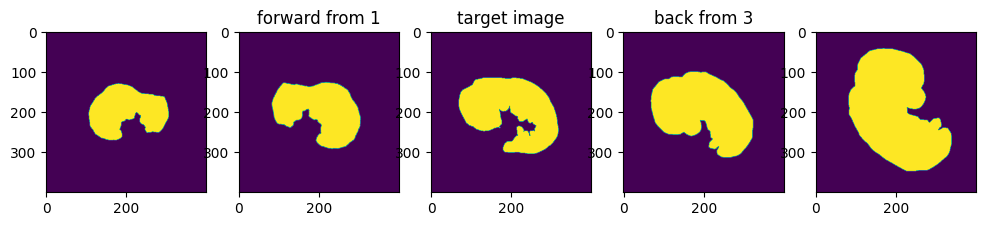

In [11]:


# manually initialize registration by shape
ref_x = torch.tensor([[-1,0],[0,1]]).float()

rot0_inits = [torch.eye(2), torch.eye(2), 0.88*rotmat(17)@ref_x, torch.eye(2), torch.eye(2)]
rot4_inits = [torch.eye(2), torch.eye(2), 1.2*(ref_x@rotmat(90)), torch.eye(2),torch.eye(2)]



mod0 = nn.Linear(2,2).cuda()
mod4 = nn.Linear(2,2).cuda()
sel = 2
mod0.weight.data = rot0_inits[sel].cuda().clone().detach().requires_grad_(True)
mod0.bias.data = torch.zeros(2,dtype = torch.float,device = 'cuda',requires_grad = True)
mod4.weight.data = rot4_inits[sel].cuda().clone().detach().requires_grad_(True)
mod4.bias.data = torch.zeros(2,dtype = torch.float,device = 'cuda',requires_grad = True)



im4 = torch.from_numpy(nonzero_ims[3]).float().cuda()[None,None]
im0 = torch.from_numpy(nonzero_ims[1]).float().cuda()[None,None]
post_0 = rotate(mod0.weight,mod0.bias,im0)[0,0].detach().cpu().numpy()
post_4 = rotate(mod4.weight,mod4.bias,im4)[0,0].detach().cpu().numpy()

# plot to check the defined rotaiton matrices look alright
figsize(12,3)
plt.subplot(1,5,1)
plt.imshow(nonzero_ims[1])
plt.subplot(1,5,2)
plt.imshow(post_0)
plt.title('forward from 1')
plt.subplot(1,5,3)
plt.imshow(nonzero_ims[2])
plt.title('target image')
plt.subplot(1,5,4)
plt.imshow(post_4)
plt.title('back from 3')
plt.subplot(1,5,5)
plt.imshow(nonzero_ims[3])
plt.show()






In [12]:
# vectorized correlation function to quantify PCC during training
@torch.no_grad()
def vec_corr(a,b,axis=0):
    na = a-a.mean(axis=axis,keepdim=True)
    nb = b-b.mean(axis=axis,keepdim=True)
    na/=(1e-5+torch.norm(na, dim = axis, keepdim=True))
    nb/=(1e-5+torch.norm(nb, dim = axis, keepdim=True))
    return (na*nb).sum(axis = axis)
    

In [13]:
# import models
from models.mixers import NMFMixer, ReLUMLPMixer, SeqPredMLPMixer,SeqAttentionMLPMixer
from models.pdes import ReactionDiffusionPDE

# specify a function that just applies a given decoder
def decode(t2ij, mixer):
    return mixer.decoder(t2ij)

# specify how we initialize the initial condition given data (just square to make sure nonnegative here)
def build_init(nonzero,start):
    return nonzero[None,None]*(start**2 ) 

out_dim = gex.shape[1]

In [14]:
# define some features for PCA
pca_gene_features = torch.pca_lowrank(tp[3][1].T, 512)[0].cpu().numpy()

In [19]:
# main training loop

out_dim = gex.shape[1]

BATCH_SIZE = 512
MAX_ITS = 200
NUM_REP = 1
ZERO_SCALE = 5.0

WARM_UP = 00
ENCODER_WEIGHT = 0

# set hyperparams to lok at
for LATENT_DIM in [40]:
    for TIMESCALE in [20]:
        for USE_GRADS in [False]:
            for DROPOUT in [True]:
                for mix in ['relu','seq']:
                    for LEARN_START in [True]:
                        if DROPOUT:
                            noise = torch.nn.Dropout(0.2)
                        else:
                            noise = torch.nn.Identity()
                            
                        if LEARN_START: 
                            # allow learning initial condition
                            LOSS_WEIGHTS = {k: 1.0 for k in [1,2,3]}
                        else:
                            # how much to weight each time point
                            LOSS_WEIGHTS = {k: 1.0 for k in [1,2,3]}
                            LOSS_WEIGHTS[1]=0
                        for rep in range(1,NUM_REP+1):
                            # number of replicates
                            t2s = {}

                            #choose decoder
                            if mix =='relu':
                                #MLP, no prior regularization
                                mixer = ReLUMLPMixer(LATENT_DIM,out_dim).cuda()
                                
                            elif mix =='seq':
                                # sequence prior
                                mixer = SeqPredMLPMixer(LATENT_DIM, out_dim,gene_features = gene_features,syntax_weight=0.01).cuda()
                            elif mix =='shuf_seq':
                                #sequence prior, shuffled
                                shuf = np.arange(len(gene_features))
                                np.random.shuffle(shuf)
                                mixer = SeqPredMLPMixer(LATENT_DIM, out_dim,gene_features = gene_features[shuf],syntax_weight=0.01).cuda()
                                
                            elif mix =='pca':
                                # use pca as gene priors
                                mixer = SeqPredMLPMixer(LATENT_DIM, out_dim,gene_features = pca_gene_features,syntax_weight=0.01).cuda()
                            else:
                                # otherwise, nmf decoder
                                mixer = NMFMixer(LATENT_DIM,out_dim).cuda()
                            

                            # initialize affine registration with previously defined transformations
                            rots = []
                            
                            rot0_inits = [torch.eye(2),torch.eye(2), 0.78*rotmat(15)@ref_x, 0.62*rotmat(90), 0.5*ref_x@rotmat(150)]
                            
                            
                            for sel in [0,1,2,3,4]:
                                mod = nn.Linear(2,2).cuda()
                                mod.weight.data = rot0_inits[sel].cuda().clone().detach().requires_grad_(True)
                                mod.bias.data = torch.zeros(2,dtype = torch.float,device = 'cuda',requires_grad = True)
                                im = torch.from_numpy(nonzero_ims[1]).float().cuda()[None,None]
                                post = rotate(mod.weight,mod.bias,im)[0,0].detach().cpu().numpy()
                                rots.append(mod)
                                rots =nn.ModuleList(rots).cuda()
                            
                            
                            
                            # initialize the initial condition to be uniform noise over regions where gex is observed at time point 1 = E10.5
                            init  = torch.rand(size,size,LATENT_DIM,device = 'cuda',dtype = torch.float)
                            init[(zero_pos[1][0][:,0], zero_pos[1][0][:,1])] = 0
                            start = init.permute(2,0,1).detach().clone().requires_grad_(True)
                            nonzero = torch.from_numpy(nonzero_ims[1]).float().cuda()
                            where_nonzero = np.where(nonzero_ims[1])
                            num_nonzero = len(where_nonzero[1])
                            

                            # initialize the PDE in the latent space
                            pde = ReactionDiffusionPDE(latent_dim = LATENT_DIM, use_grads = USE_GRADS, diffusion_type = 'variable').cuda()
                            torch.nn.init.normal_(pde.reaction[0].weight, 0.01)
                            torch.nn.init.zeros_(pde.ldiff)

                            # build optimizers
                            pde_opt = torch.optim.Adam(list(pde.parameters()) +[start]  ,lr = 0.001) 
                            opt = torch.optim.Adam(list(mixer.parameters()),lr = 0.001)
                            rot_opt = torch.optim.Adam(list(rots.parameters()) ,lr = 0.001) #do not learn scale
                            
                            # dicts to collect losses
                            ge_losses = {1:[], 2:[],3:[]}
                            zero_losses = {1:[],2:[],3:[]}
                            enc_losses = {1:[],2:[],3:[]}
                            val_loss = {}
                            val_corr = {}

                            # training loop
                            for its in tqdm(range(MAX_ITS+WARM_UP)):
                                imgs = []
                                sum_imgs = []
                                ims = []
                                loss = 0
                                bias_reg = 0
                            

                                # need to build params because we want to ensure nonnegativity etc
                                mixer.build_params()
                                pde.build_params()
                                
                            
                                sf = 1
                                # only work on E10.5 and E12.5, ignore E11.5
                                for sel in [1,3]:
                                    co, ge = tp[sel]
                                    samp = np.random.choice(new_idxs[sel], BATCH_SIZE)
                                    coord = pos[sel][samp]
                                    i,j = (coord[:,0],coord[:,1])
                            
                                    zer, zer_inds,ratio = zero_pos[sel]
                                    zer_samp = np.random.choice(zer_inds, int(ratio*BATCH_SIZE))
                                    zer_coord = zer[zer_samp]
                                    zer_i,zer_j = (zer_coord[:,0], zer_coord[:,1])
                            
                                    
                                    if sel ==1:
                                        # simply initialize
                                        initial = build_init(nonzero,start)
                                        # reshape to extract latent dimensions that can be indexed by positions
                                        t2 = initial[0].permute(1,2,0)
                                        
                                        # apply noise to initial condition
                                        temp = noise(initial)
                            
                                    # step through the PDE
                                    if sel ==3:
                                        for _ in range(TIMESCALE):
                                            temp = pde.step(temp)

                                        # apply affine transformation for second time point
                                        t2 = rotate(rots[sel].weight,rots[sel].bias,temp)[0].permute(1,2,0)

                                        # regularize the bias to stop it floating away
                                        bias_reg += 10*torch.square(rots[sel].bias).sum()
                            
                            
                                    # gex loss
                                    ge_loss = torch.square((sf*decode(t2[(i,j)],mixer) - ge[samp])).mean() 

                                    #zero loss
                                    zero_loss = ZERO_SCALE*torch.square(decode(t2[(zer_i,zer_j)],mixer) ).mean()

                                    # weight each loss
                                    loss+=LOSS_WEIGHTS[sel]*(ge_loss + zero_loss)
                                    
                                    ge_losses[sel].append(ge_loss.item())
                                    zero_losses[sel].append(zero_loss.item())

                                    # store the latent image for visualization
                                    ims.append(t2.detach().cpu().numpy())
                                    
                                    t2s[sel] = t2.detach().cpu().numpy()

                                
                                opt.zero_grad()
                                pde_opt.zero_grad()
                                rot_opt.zero_grad() 
                                # regularize mixer
                                mixer_reg = mixer.reg()
                                pde_reg = pde.reg()

                                #backward through everything
                                (loss+  mixer_reg + pde_reg).backward()
                                
                                if its<WARM_UP:
                                    continue

                                #step opts
                                pde_opt.step()
                                opt.step()

                                # only update registration 90% of the time
                                if np.random.rand()<0.9:
                                    rot_opt.step()

                                # validation every 100 steps
                                if (its%100) ==0:
                                    for k in val_pos:
                                        vpi, vpj = (val_pos[k][:,0],val_pos[k][:,1])
                                        vpsamp = val_ind[k]
                                        val_loss.setdefault(len(ge_losses[1]), {})[k] = torch.square((sf*decode(t2[(vpi,vpj)],mixer) - ge[vpsamp])).mean().item()
                                        val_corr.setdefault(len(ge_losses[1]), {})[k] = (vec_corr(sf*decode(t2[(vpi,vpj)],mixer), ge[vpsamp]).detach().cpu().numpy()>0.1).sum()
                                    
                                    
                               
                            # save output s
                            torch.save({'mix':mixer.state_dict(), 'pde': pde.state_dict(), 'rots':rots.state_dict(),'start':start,'ge_losses':ge_losses,'val_loss':val_loss,'val_corr':val_corr}, 'results/test/inpainting_grads_{}_LD_{}_TS_{}_rep_{}_dropout_{}_mix_{}_learnstart_{}'.format(USE_GRADS,LATENT_DIM,TIMESCALE,rep,DROPOUT,mix,LEARN_START))    
                                
                                

 51%|██████████████████████████████████████████████████████████████████████████████████                                                                               | 10198/20000 [29:59<28:44,  5.69it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13330/20000 [39:30<19:14,  5.78it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/s